In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import datetime as dt
from math import log, sqrt, exp
from scipy import stats
idx = pd.IndexSlice
import cufflinks as cf 
import plotly.express as px

In [2]:
# helper scripts
import bsm_imp_vol as bs
from helper_funcs import simpath as simpath
from helper_funcs import bs_call as bs_call
from helper_funcs import bs_delta as bs_delta
from helper_funcs import delta_hedge as delta_hedge
from helper_funcs import hedge_error as hedge_error
from helper_funcs import stoploss as stoploss


from helper_funcs import ttm_vector as ttm_vec

# import cs_gbm_sim as gbm

# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 10
# matplotlib.rcParams['lines.linewidth'] = 0.3

# Set max row to 300
pd.set_option('display.max_rows', 300)

### Set parameters

In [16]:
S0 = 100
strike = 100
ttm = 1 # 1 year
r = 0.05
sigma = 0.2
numSteps = 500
numPaths = 10
quantity = 10000
epsilon = 0.02

### Price the call

In [4]:
call0 = bs_call(S0, strike, sigma, ttm, r)
print(f' call price is: {call0}')

 call price is: 10.450583572185565


### Generate paths and plot

Text(0, 0.5, 'freq')

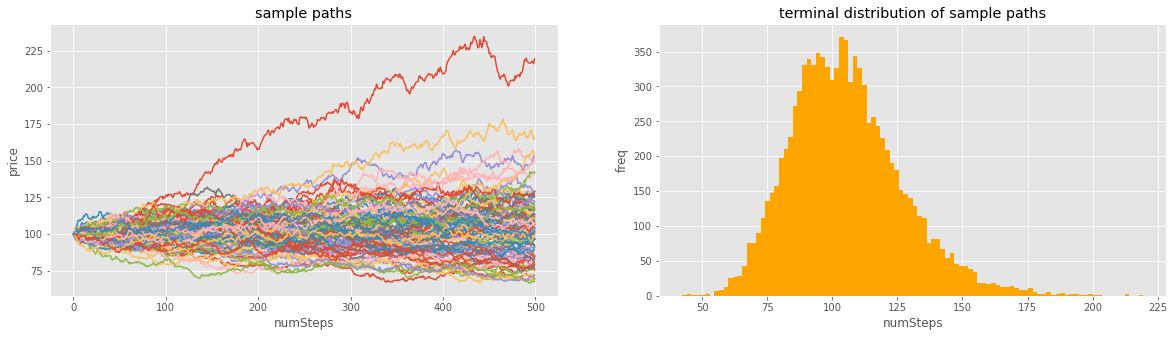

In [7]:
paths = pd.DataFrame(simpath(S0, r, sigma, ttm, numSteps, numPaths))
# paths.shape

figure, axes = plt.subplots(1, 2, figsize=(20,5))
axes[0].plot(paths.iloc[:, 0:100]);
axes[0].set_title('sample paths')
axes[0].set_xlabel('numSteps')
axes[0].set_ylabel('price')

axes[1].hist(paths.iloc[-1],color='orange', bins=100);
axes[1].set_title('terminal distribution of sample paths')
axes[1].set_xlabel('numSteps')
axes[1].set_ylabel('freq')

In [8]:
# ttm vector
ttm_vec_ = ttm_vec(ttm, numSteps, numPaths)
ttm_vec_.shape

(500, 10000)

### Create the delta hedge strategy dataframe

In [9]:
dhedge_strat = delta_hedge(S0, strike, sigma, r, ttm, numSteps, numPaths, quantity)
dhedge_strat.iloc[-5:,:]

path                                                               \
         0       1       2       3      4      5       6      7       8   
495  98.29  120.09  125.30  120.58  96.34  76.57  151.11  72.04  107.56   
496  98.13  120.74  125.89  119.29  96.45  75.82  150.06  71.88  106.90   
497  95.70  121.31  126.97  119.24  96.59  75.60  149.12  71.43  106.22   
498  95.71  120.37  128.60  115.93  98.76  75.54  148.39  70.41  107.30   
499  96.39  119.36  129.46  117.90  99.58  75.11  150.13  69.16  106.37   

             ...    ttmvec                                                    \
          9  ...      9990      9991      9992      9993      9994      9995   
495  125.99  ...  1.00e-02  1.00e-02  1.00e-02  1.00e-02  1.00e-02  1.00e-02   
496  125.08  ...  8.00e-03  8.00e-03  8.00e-03  8.00e-03  8.00e-03  8.00e-03   
497  125.63  ...  6.00e-03  6.00e-03  6.00e-03  6.00e-03  6.00e-03  6.00e-03   
498  125.77  ...  4.00e-03  4.00e-03  4.00e-03  4.00e-03  4.00e-03  4.00e-03   
499  126.59  ...  1.00e-08  1.00e-08  1.00e-08  1.00e-08  1.00e-08  1.00e-08   

                                             
         9996      9997      9998      9999  
495  1.00e-02  1.00e-02  1.00e-02  1.00e-02  
496  8.00e-03  8.00e-03  8.00e-03  8.00e-03  
497  6.00e-03  6.00e-03  6.00e-03  6.00e-03  
498  4.00e-03  4.00e-03  4.00e-03  4.00e-03  
499  1.00e-08  1.00e-08  1.00e-08  1.00e-08  

[5 rows x 60000 columns]

### Analyze the results for a specific path

In [10]:
pathNum = '0'
# hedge_strat.iloc[0:5, hedge_strat.columns.get_level_values(1)== pathNum]
dhedge_strat.iloc[-5:, dhedge_strat.columns.get_level_values(1)== pathNum]

,path,delta,stockpos,stockcuml,intcost,ttmvec
,0,0,0,0,0,0
495,98.29,2.04e-01,-312019.23,314451.47,62.64,1.00e-02
496,98.13,1.53e-01,-49582.72,264900.20,31.45,8.00e-03
497,95.70,2.47e-03,-144080.93,120845.77,26.49,6.00e-03
498,95.71,2.89e-04,-2085.17,118772.69,12.09,4.00e-03
499,96.39,0.00e+00,-278.49,118506.07,11.88,1.00e-08


### Calc. hedge error

In [11]:
dhedge_err = hedge_error(call0, dhedge_strat, strike, sigma, ttm, r, numSteps, numPaths, quantity)
# hedge_error = pd.DataFrame(hedge_results[0]).flatten()
# hedge_results[0][0,1]

In [12]:
dhedge_err_ = pd.DataFrame(dhedge_err[0].flatten(), columns=['hedge_error'])
dhedge_err_.index.rename('numPaths', inplace=True)
avg_hedge_err_ = dhedge_err_.mean()
avg_hedge_err_

hedge_error   -0.52
dtype: float64

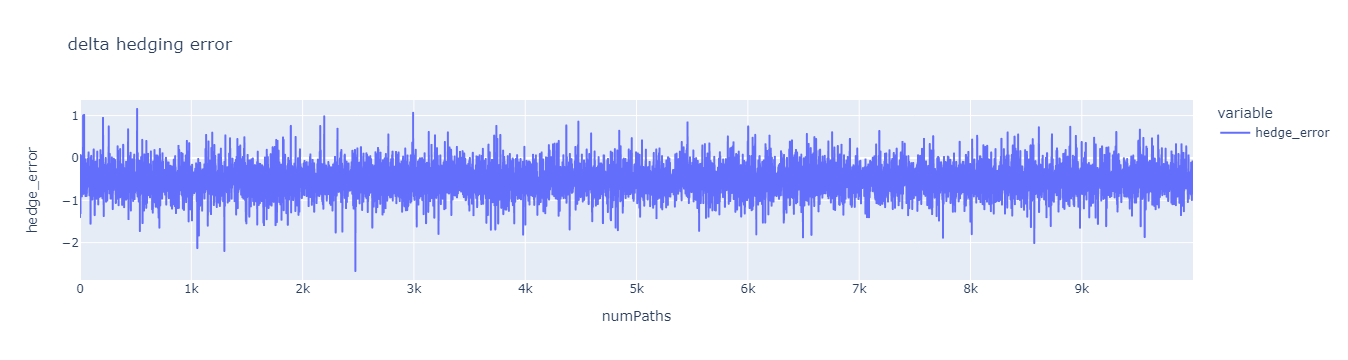

In [13]:
fig = px.line(dhedge_err_, title = 'delta hedging error',
             labels = {
                 "value":"hedge_error"
                       
                      })

fig.show()

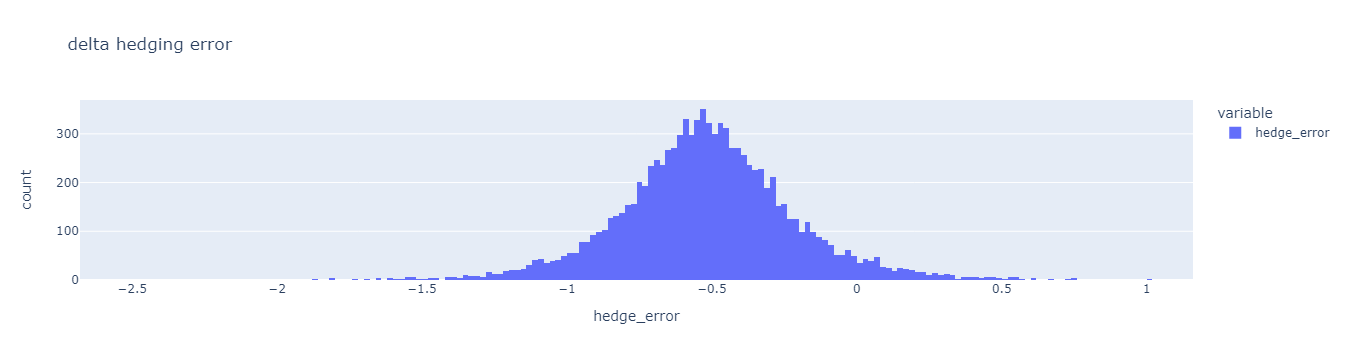

In [14]:
fig = px.histogram(dhedge_err_, title = 'delta hedging error',
                  labels={
                      "value": "hedge_error"
                  })

fig.show()

### Delta vs stock price for the entire path of a choosen simulation

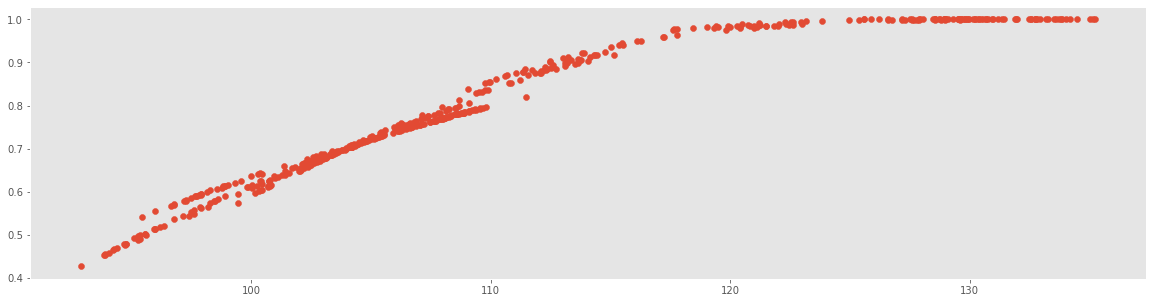

In [27]:
figsize=(20,5)
mysim = '100'
x = dhedge_strat.iloc[:, dhedge_strat.columns.get_level_values(1)== mysim]['path']
y = dhedge_strat.iloc[:, dhedge_strat.columns.get_level_values(1)== mysim]['delta']


plt.figure(figsize=figsize);
plt.scatter(x, y);
plt.grid()

### Delta vs. stock price for all sims at specific points in time (cross-section)

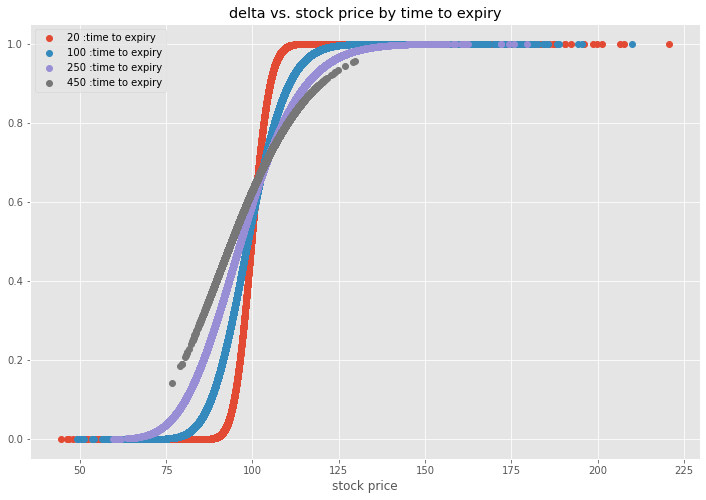

In [28]:
time_to_exp = [20, 100, 250, 450]

for ts in time_to_exp:
    slice_path = dhedge_strat['path'].iloc[-ts-1:-ts,:]
    slice_delta = dhedge_strat['delta'].iloc[-ts-1:-ts,:]
    plt.scatter(slice_path, slice_delta, linewidths=1, label=str(ts) + str(' :time to expiry'));

plt.title('delta vs. stock price by time to expiry')
plt.xlabel('stock price');
plt.legend();

### Stop loss strategy

In [17]:
stoploss_strat = stoploss(sigma, strike, ttm, epsilon, numSteps, numPaths, call0)

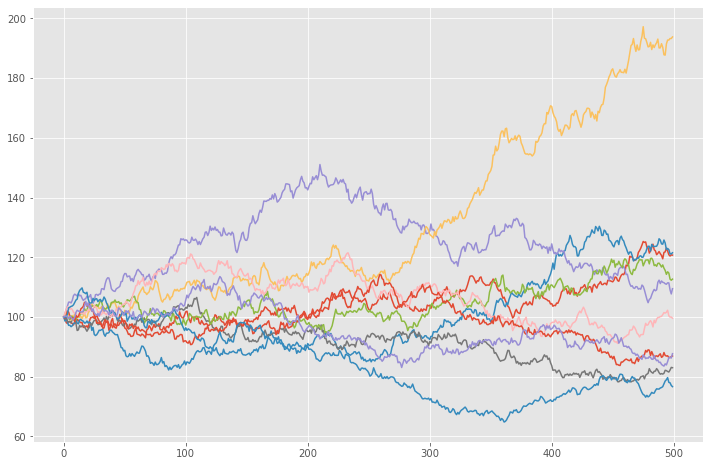

In [18]:
plt.plot(stoploss_strat[0]);

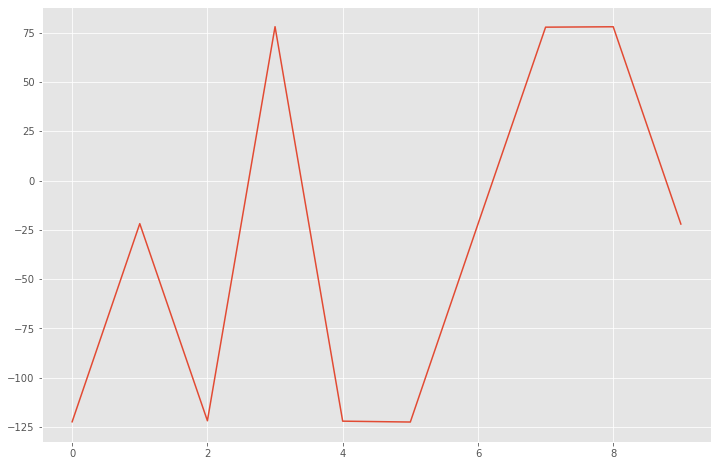

In [22]:
# plt.bar(numPaths, stoploss_strat[3][0,:]);
plt.plot(stoploss_strat[3][0,:]);

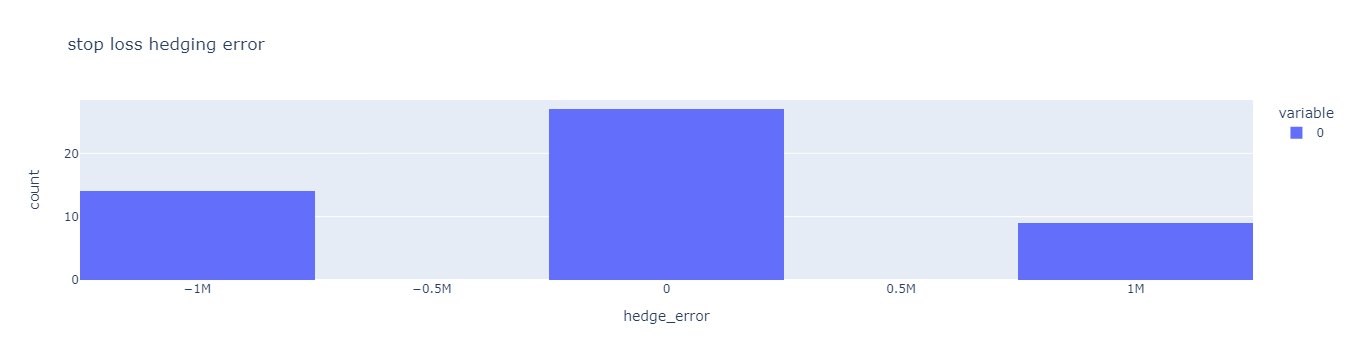

In [14]:
slhedge_err = stoploss_strat[2][0, :]
fig = px.histogram(slhedge_err, title = 'stop loss hedging error',
                  labels={
                      "value": "hedge_error"
                  })

fig.show()


### scratch

In [15]:
ts = 450
slice_path = dhedge_strat['path'].iloc[-ts-1:-ts,:]
slice_delta = dhedge_strat['delta'].iloc[-ts-1:-ts,:]
slice_path

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
49,112.86,93.66,94.44,93.09,93.91,100.03,106.48,92.34,106.37,94.4,...,99.23,98.66,94.73,93.37,106.59,100.5,104.11,109.19,102.92,87.3


In [10]:
# send file to csv
csv_name = 'hedge'
fname = os.path.join(fpath1, csv_name +'.' + 'csv')
hedge_strat.to_csv(fname)